## Retrieving the Data

We use the EPA **AQS dailyData** endpoint to pull daily PM2.5 (`parameter_code = 88101`) with AQI values for Middlesex County, New Jersey in 2020. The response comes back in JSON, which we save locally.


## Data Source

All air quality data used here comes from Rutgers (via the EPA AQS dailyData endpoint).


In [1]:
# Pull PM2.5 daily data from EPA AQS and save locally
import requests
import json

# API auth/key and county parameters
email = "igoldin670@gmail.com"
key = "NA"

daily_url = "https://aqs.epa.gov/data/api/dailyData/byCounty"
params = {
    "email": email,
    "key": key,
    "param": "88101",
    "bdate": "20200101",
    "edate": "20201231",
    "state": "34",
    "county": "023",  # Middlesex County
}

# Request data and attach county name for clarity
response = requests.get(daily_url, params=params)
payload = response.json()
rows = payload.get("Data", [])
for row in rows:
    row["county_name"] = "Middlesex"

# Persist raw daily payload to JSON for reuse
with open("pm25_middlesex_2020_daily.json", "w") as f:
    json.dump({"Data": rows}, f, indent=2)


In [2]:
"""
The JSON file contains daily PM2.5 values with AQI for Middlesex County:
- `date_local`, `aqi`, and daily means (`arithmetic_mean`, `first_max_value`)
- monitoring site/location info (site number, latitude, longitude)
- quality metadata (`method`, `qualifier`)
"""
import pandas as pd

with open("pm25_middlesex_2020_daily.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data["Data"])
df.columns


Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code',
       'sample_duration', 'pollutant_standard', 'date_local',
       'units_of_measure', 'event_type', 'observation_count',
       'observation_percent', 'validity_indicator', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method',
       'local_site_name', 'site_address', 'state', 'county', 'city',
       'cbsa_code', 'cbsa', 'date_of_last_change', 'county_name'],
      dtype='object')

## Plotting the Data

Plot daily PM2.5 (arithmetic mean) with a 7-day rolling trend, and overlay AQI to see how concentration tracks with index levels. The AQS dailyData endpoint already provides daily values, so we just convert `date_local` to datetime and sort before plotting.


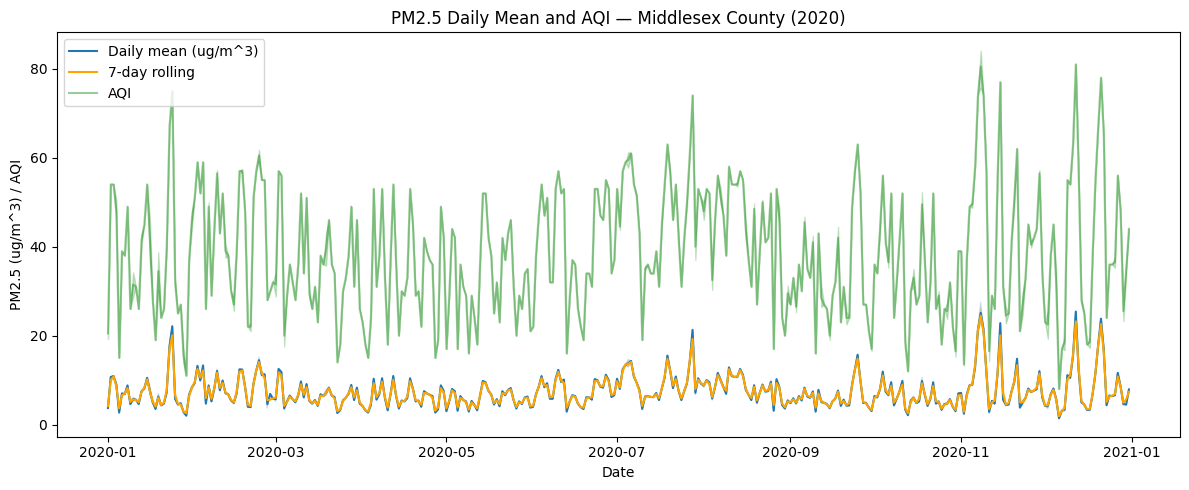

In [3]:
# Plot daily PM2.5 alongside 7-day trend and AQI overlay
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure dates are datetime and sorted
df['date_local'] = pd.to_datetime(df['date_local'])
daily = df.sort_values('date_local')

plt.figure(figsize=(12, 5))
sns.lineplot(data=daily, x='date_local', y='arithmetic_mean', label='Daily mean (ug/m^3)')
sns.lineplot(
    data=daily.assign(roll_7=daily['arithmetic_mean'].rolling(7, center=True).mean()),
    x='date_local',
    y='roll_7',
    label='7-day rolling',
    color='orange',
)
sns.lineplot(data=daily, x='date_local', y='aqi', label='AQI', color='green', alpha=0.4)
plt.title('PM2.5 Daily Mean and AQI — Middlesex County (2020)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (ug/m^3) / AQI')
plt.tight_layout()
plt.show()


## Additional Trend Visualizations

Run the charts below to check for seasonal patterns, AQI distribution, day-of-week differences, and how closely PM2.5 tracks AQI.


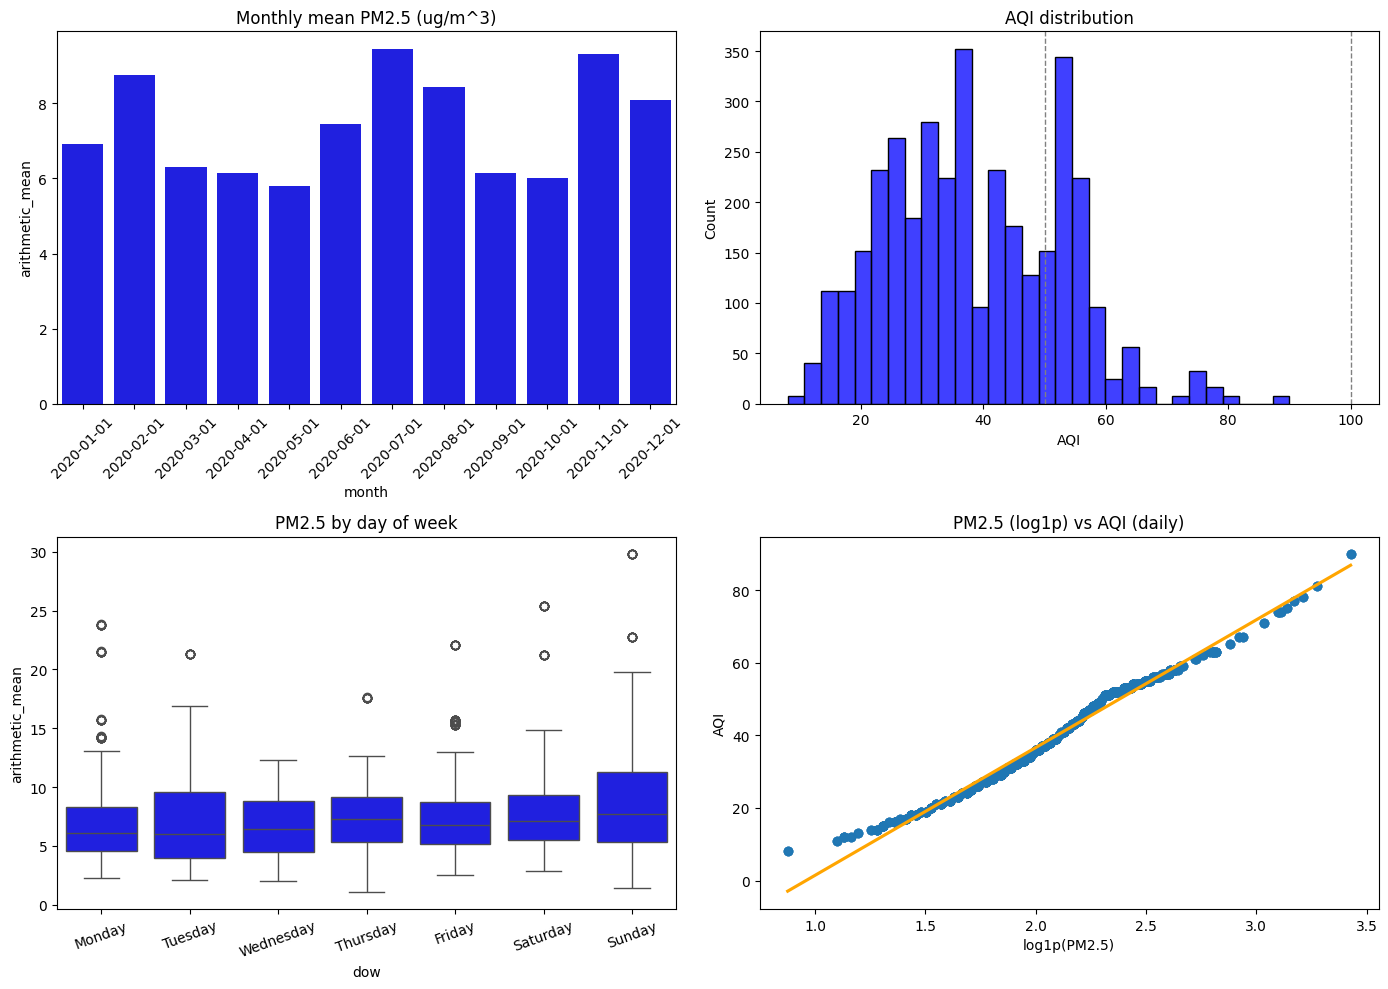

In [4]:
# Feature engineering and seasonal plots for PM2.5/AQI
import numpy as np
df['date_local'] = pd.to_datetime(df['date_local'])
daily = df.sort_values('date_local').assign(
    month=lambda x: x['date_local'].dt.to_period('M'),
    dow=lambda x: x['date_local'].dt.day_name(),
    pm25_log=lambda x: np.log1p(x['arithmetic_mean']),
)
monthly = daily.groupby('month', as_index=False)['arithmetic_mean'].mean()
monthly['month'] = monthly['month'].dt.to_timestamp()
week_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.barplot(data=monthly, x='month', y='arithmetic_mean', ax=axes[0,0], color='blue')
axes[0,0].set_title('Monthly mean PM2.5 (ug/m^3)')
axes[0,0].tick_params(axis='x', rotation=45)

sns.histplot(data=daily, x='aqi', bins=30, ax=axes[0,1], color='blue')
axes[0,1].axvline(50, color='gray', linestyle='--', linewidth=1)
axes[0,1].axvline(100, color='gray', linestyle='--', linewidth=1)
axes[0,1].set_title('AQI distribution')
axes[0,1].set_xlabel('AQI')

sns.boxplot(data=daily, x='dow', y='arithmetic_mean', order=week_order, ax=axes[1,0], color='blue')
axes[1,0].set_title('PM2.5 by day of week')
axes[1,0].tick_params(axis='x', rotation=20)

sns.regplot(data=daily, x='pm25_log', y='aqi', ax=axes[1,1], scatter_kws={'alpha':0.4}, line_kws={'color':'orange'})
axes[1,1].set_title('PM2.5 (log1p) vs AQI (daily)')
axes[1,1].set_xlabel('log1p(PM2.5)')
axes[1,1].set_ylabel('AQI')

plt.tight_layout()
plt.show()


## Takeaways from the Graph

From the current charts, daily PM2.5 in Middlesex stays mostly in the Good/Moderate range with occasional spikes. Monthly means lean higher in cooler months and can show a spring bump, likely a mix of heating-season inversions and springtime biological particles. while summer looks cleaner overall. 

AQI mirrors this pattern, clustering around low values with few unhealthy days, and the PM2.5-AQI scatter is nearly linear (as expected since AQI is derived from concentration).

Those isolated spikes are the ones to watch: they probably align with stagnant or low-wind periods and elevated humidity (or pollen), so pulling matching meteorological data (wind speed/direction, temperature, humidity, pressure/mixing height) will help explain and predict them. The flat weekday/weekend boxplot suggests day-of-week is a weak signal compared to seasonal and meteorological drivers.


## Next Step

Now since we have got all the data for PM2.5 and AQI, we have to link it with another dataset where we can get meteorological data. After data collection we can data clean and make sure our data is ready to graph to see any trends then after that we can take action on creating a model.

## Data Sources and Merge Approach

We pull PM2.5 and AQI daily values from the EPA AQS dailyData endpoint (Rutgers) into `pm25_middlesex_2020_daily.json`, and meteorological stats for the same coordinates/dates from the Open-Meteo archive into `meteo_middlesex_2020_daily.json`. After loading both, we convert the date columns to datetimes, rename the meteo `time` column to `date_local`, and merge on `date_local` (inner join) so each row has aligned air quality and weather features.

In [5]:
# Pull daily weather features from Open-Meteo archive for Middlesex County
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 40.462182,
    "longitude": -74.429439,
    "start_date": "2020-01-01",
    "end_date": "2020-12-31",
    "daily": [
        "temperature_2m_max",
        "temperature_2m_min",
        "temperature_2m_mean",
        "relative_humidity_2m_mean",
        "windspeed_10m_max",
        "windgusts_10m_max",
        "surface_pressure_mean",
        "precipitation_sum",
        "shortwave_radiation_sum"
    ],
    "timezone": "America/New_York"
}

response = requests.get(url, params=params)
meteo = response.json()

with open("meteo_middlesex_2020_daily.json", "w") as f:
    json.dump(meteo, f, indent=2)


In [6]:
# Load FULL PM2.5 dataset (no column removal)
with open("pm25_middlesex_2020_daily.json", "r") as f:
    pm_payload = json.load(f)

df_pm25 = pd.DataFrame(pm_payload["Data"])

# Convert date column to datetime
df_pm25["date_local"] = pd.to_datetime(df_pm25["date_local"])

# Load meteorological dataset
with open("meteo_middlesex_2020_daily.json", "r") as f:
    meteo_payload = json.load(f)

daily = meteo_payload["daily"]
df_meteo = pd.DataFrame(daily)

# Rename time column to match PM2.5 date
df_meteo = df_meteo.rename(columns={"time": "date_local"})
df_meteo["date_local"] = pd.to_datetime(df_meteo["date_local"])

# Merge without dropping any PM2.5 columns
df_merged = pd.merge(df_pm25, df_meteo, on="date_local", how="inner")

# Inspect result
print(df_merged.columns)
df_merged.head()

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code',
       'sample_duration', 'pollutant_standard', 'date_local',
       'units_of_measure', 'event_type', 'observation_count',
       'observation_percent', 'validity_indicator', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method',
       'local_site_name', 'site_address', 'state', 'county', 'city',
       'cbsa_code', 'cbsa', 'date_of_last_change', 'county_name',
       'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
       'relative_humidity_2m_mean', 'windspeed_10m_max', 'windgusts_10m_max',
       'surface_pressure_mean', 'precipitation_sum',
       'shortwave_radiation_sum'],
      dtype='object')


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,county_name,temperature_2m_max,temperature_2m_min,temperature_2m_mean,relative_humidity_2m_mean,windspeed_10m_max,windgusts_10m_max,surface_pressure_mean,precipitation_sum,shortwave_radiation_sum
0,34,023,0011,88101,1,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,7,...,Middlesex,4.5,-1.5,2.0,58,25.5,51.8,1006.3,0.0,7.75
1,34,023,0011,88101,1,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,7,...,Middlesex,4.5,-1.5,2.0,58,25.5,51.8,1006.3,0.0,7.75
2,34,023,0011,88101,1,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,7,...,Middlesex,4.5,-1.5,2.0,58,25.5,51.8,1006.3,0.0,7.75
3,34,023,0011,88101,1,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,7,...,Middlesex,4.5,-1.5,2.0,58,25.5,51.8,1006.3,0.0,7.75
4,34,023,0011,88101,1,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,7,...,Middlesex,4.5,-1.5,2.0,58,25.5,51.8,1006.3,0.0,7.75


## Cleaning the merged dataset

We standardize datatypes, drop obvious bad values, and keep one row per date so the modeling data is tidy: convert numeric columns, remove negative PM2.5, drop NA in target/features, and sort/deduplicate by date.

In [7]:
# Clean merged data for modeling

target = 'arithmetic_mean'
feature_cols = [
    'temperature_2m_mean',
    'relative_humidity_2m_mean',
    'windspeed_10m_max',
    'surface_pressure_mean',
    'precipitation_sum',
    'shortwave_radiation_sum',
]
numeric_cols = [target, 'aqi'] + feature_cols
df_clean = df_merged.copy()
# keep one record per date and preserve order
df_clean = df_clean.sort_values('date_local').drop_duplicates(subset=['date_local'])
# coerce relevant fields to numeric for modeling
df_clean[numeric_cols] = df_clean[numeric_cols].apply(pd.to_numeric, errors='coerce')
# drop physically impossible negatives
df_clean = df_clean[df_clean[target] >= 0]
# drop rows missing any modeling fields
df_clean = df_clean.dropna(subset=numeric_cols)
print('Cleaned rows:', len(df_clean), 'of', len(df_merged))
df_clean.head()


Cleaned rows: 297 of 3942


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,county_name,temperature_2m_max,temperature_2m_min,temperature_2m_mean,relative_humidity_2m_mean,windspeed_10m_max,windgusts_10m_max,surface_pressure_mean,precipitation_sum,shortwave_radiation_sum
0,34,023,0011,88101,1,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,7,...,Middlesex,4.5,-1.5,2.0,58,25.5,51.8,1006.3,0.0,7.75
692,34,023,0011,88101,3,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,X,...,Middlesex,9.4,-2.6,3.0,69,14.3,31.3,1011.3,0.0,8.22
702,34,023,0011,88101,3,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,X,...,Middlesex,9.5,5.7,7.4,88,13.2,27.0,1007.7,5.6,2.57
712,34,023,0011,88101,3,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,X,...,Middlesex,12.1,4.6,8.6,95,21.7,42.5,1001.4,6.5,1.85
722,34,023,0011,88101,3,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,X,...,Middlesex,5.4,0.4,3.0,57,29.7,61.2,1008.6,0.3,8.03


## Patterns in the merged PM2.5 + weather data

Correlations and simple scatter plots below highlight how PM2.5/AQI relate to temperature and humidity using the merged dataset.

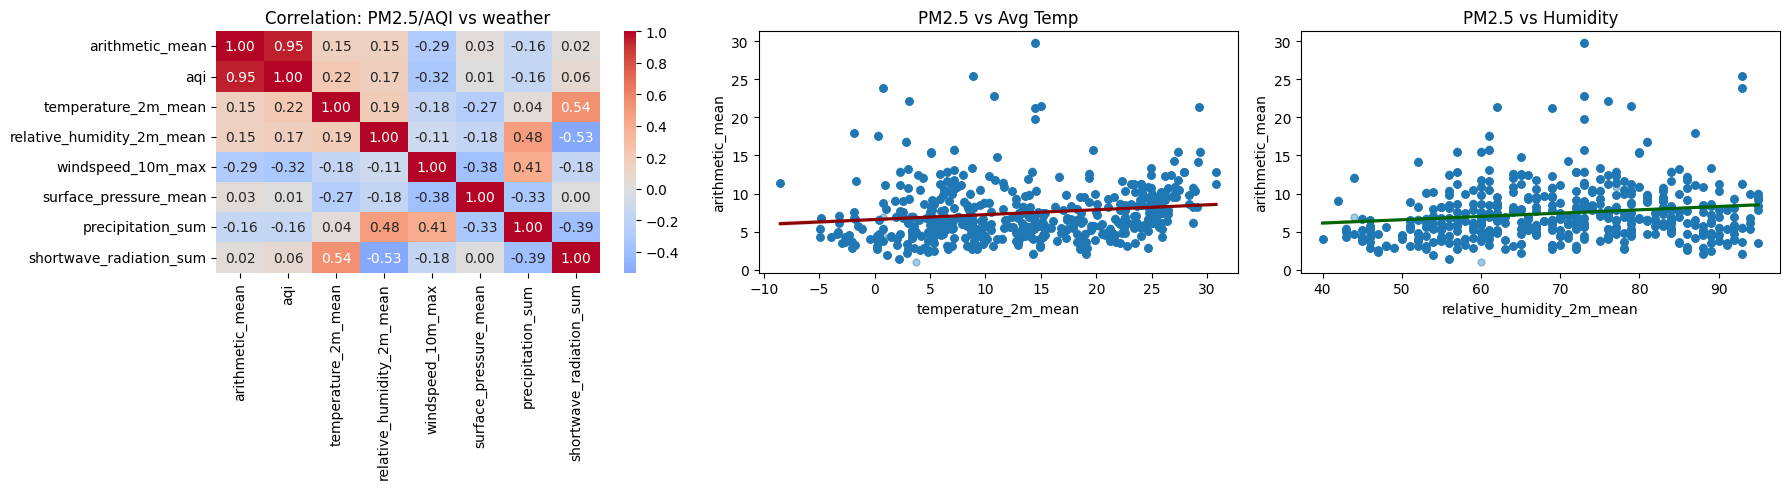

In [8]:
# Quick pattern check on merged air quality + meteorology
numeric_features = [
    'arithmetic_mean',
    'aqi',
    'temperature_2m_mean',
    'relative_humidity_2m_mean',
    'windspeed_10m_max',
    'surface_pressure_mean',
    'precipitation_sum',
    'shortwave_radiation_sum',
]

# correlation matrix across numeric fields
corr = df_merged[numeric_features].corr()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(corr, ax=axes[0], cmap='coolwarm', center=0, annot=True, fmt='.2f')
axes[0].set_title('Correlation: PM2.5/AQI vs weather')

# scatter + trend vs temperature
sns.regplot(
    data=df_merged,
    x='temperature_2m_mean',
    y='arithmetic_mean',
    scatter_kws={'alpha': 0.4, 's': 25},
    line_kws={'color': 'darkred'},
    ax=axes[1],
)
axes[1].set_title('PM2.5 vs Avg Temp')

# scatter + trend vs humidity
sns.regplot(
    data=df_merged,
    x='relative_humidity_2m_mean',
    y='arithmetic_mean',
    scatter_kws={'alpha': 0.4, 's': 25},
    line_kws={'color': 'darkgreen'},
    ax=axes[2],
)
axes[2].set_title('PM2.5 vs Humidity')

plt.tight_layout()


## Linear patterns vs temperature and humidity

### The PM2.5 and AQI scatter plots suggest a roughly linear trend with average temperature and relative humidity. The cell below quantifies that by fitting simple lines and reporting the slope/intercept (y = mx + b), R value, and MSE.

In [9]:
#Fit simple linear models for individual weather features vs PM2.5/AQI
def fit_line(x, y):
    mask = x.notna() & y.notna()
    x_clean = x[mask].astype(float)
    y_clean = y[mask].astype(float)
    n = len(x_clean)
    m, b = np.polyfit(x_clean, y_clean, 1)
    y_hat = m * x_clean + b
    mse = ((y_clean - y_hat) ** 2).mean()
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    adj_r2 = 1 - (1 - r**2) * (n - 1) / (n - 2) if n > 2 else np.nan
    return m, b, r, adj_r2, mse

pairs = [
    ('arithmetic_mean', 'temperature_2m_mean', 'PM2.5 vs Avg Temp'),
    ('arithmetic_mean', 'relative_humidity_2m_mean', 'PM2.5 vs Humidity'),
    ('aqi', 'temperature_2m_mean', 'AQI vs Avg Temp'),
    ('aqi', 'relative_humidity_2m_mean', 'AQI vs Humidity'),
]

for target, feature, label in pairs:
    m, b, r, adj_r2, mse = fit_line(df_clean[feature], df_clean[target])
    print(f"\n{label}")
    print(f"  y = {m:.4f}x + {b:.4f}")
    print(f"  r = {r:.4f}, adjusted r^2 = {adj_r2:.4f}")
    print(f"  MSE = {mse:.4f}")



PM2.5 vs Avg Temp
  y = 0.0408x + 7.0577
  r = 0.0907, adjusted r^2 = 0.0049
  MSE = 15.4472

PM2.5 vs Humidity
  y = 0.0500x + 4.1127
  r = 0.1724, adjusted r^2 = 0.0264
  MSE = 15.1125

AQI vs Avg Temp
  y = 0.2721x + 35.3043
  r = 0.1647, adjusted r^2 = 0.0238
  MSE = 204.0907

AQI vs Humidity
  y = 0.2008x + 24.9113
  r = 0.1888, adjusted r^2 = 0.0324
  MSE = 202.3018


### The r values are low, so the linear correlations are weak; adjusted r^2 reinforces that even when MSE looks small.

### Since I feel simple linear model clearly doesn't seem to be the best fit, let's try a multivariate model to see anything.

In [10]:
# Try a multivariate linear model to capture more signal (scikit-learn)
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
# Define target and feature set
target = 'arithmetic_mean'  # predict PM2.5
features = [
    'temperature_2m_mean',
    'relative_humidity_2m_mean',
    'windspeed_10m_max',
    'surface_pressure_mean',
    'precipitation_sum',
    'shortwave_radiation_sum',
]

# Train OLS model and report metrics
data = df_clean.dropna(subset=[target] + features).copy()
X = data[features].astype(float)
y = data[target].astype(float)
model = LinearRegression()
model.fit(X, y)
y_hat = model.predict(X)
mse = mean_squared_error(y, y_hat)
r2 = r2_score(y, y_hat)
n, p = X.shape
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p + 1 else np.nan

print('Multivariate linear model for PM2.5 (arithmetic_mean)')
print('Features:', features)
print('y = b + sum(m_i * x_i) where b is intercept below')
print(f'intercept (b): {model.intercept_:.4f}')
for name, m in zip(features, model.coef_):
    print(f'  {name}: {m:.4f}')
print(f'R^2: {r2:.4f}, adjusted R^2: {adj_r2:.4f}')
print(f'MSE: {mse:.4f}')


Multivariate linear model for PM2.5 (arithmetic_mean)
Features: ['temperature_2m_mean', 'relative_humidity_2m_mean', 'windspeed_10m_max', 'surface_pressure_mean', 'precipitation_sum', 'shortwave_radiation_sum']
y = b + sum(m_i * x_i) where b is intercept below
intercept (b): 27.2294
  temperature_2m_mean: 0.0361
  relative_humidity_2m_mean: 0.0443
  windspeed_10m_max: -0.1040
  surface_pressure_mean: -0.0196
  precipitation_sum: -0.1276
  shortwave_radiation_sum: -0.0681
R^2: 0.1128, adjusted R^2: 0.0945
MSE: 13.8181


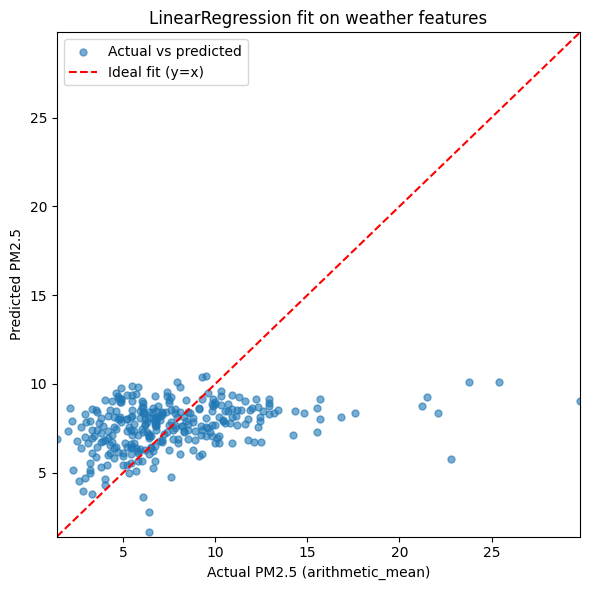

In [11]:
# Visualize existing LinearRegression fit: actual vs predicted PM2.5
y_hat = model.predict(X)

plt.figure(figsize=(6, 6))
plt.scatter(y, y_hat, alpha=0.6, s=25, label='Actual vs predicted')
lims = [min(y.min(), y_hat.min()), max(y.max(), y_hat.max())]
plt.plot(lims, lims, 'r--', label='Ideal fit (y=x)')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('Actual PM2.5 (arithmetic_mean)')
plt.ylabel('Predicted PM2.5')
plt.title('LinearRegression fit on weather features')
plt.legend()
plt.tight_layout()
plt.show()


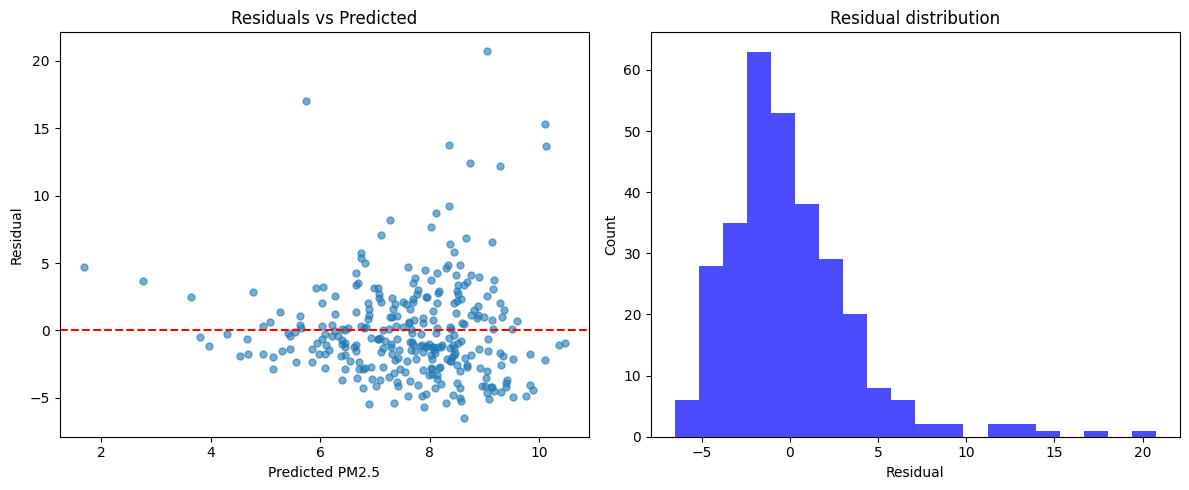

In [12]:
# Residual diagnostics for LinearRegression
resid = y - y_hat

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(y_hat, resid, alpha=0.6, s=25)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted PM2.5')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residuals vs Predicted')

axes[1].hist(resid, bins=20, alpha=0.7, color='blue')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Count')
axes[1].set_title('Residual distribution')
plt.tight_layout()
plt.show()


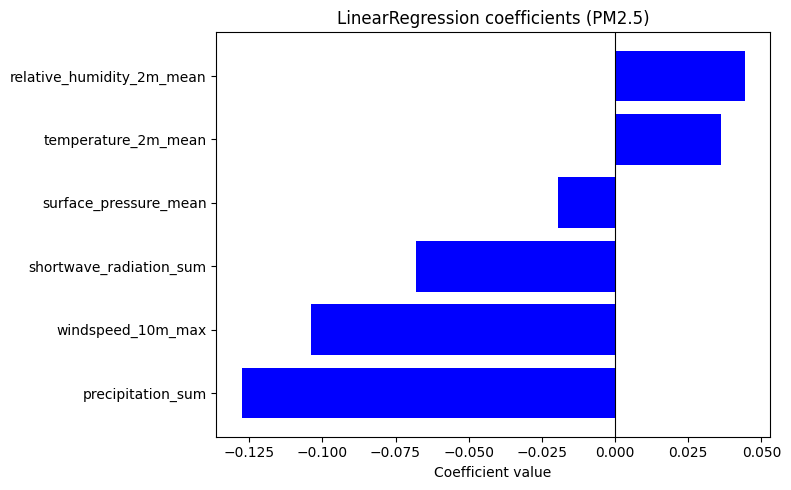

In [13]:
# Coefficient magnitudes for LinearRegression
coefs = model.coef_
idx = np.argsort(coefs)
sorted_features = np.array(features)[idx]
sorted_coefs = coefs[idx]
plt.figure(figsize=(8, 5))
plt.barh(sorted_features, sorted_coefs, color='blue')
plt.axvline(0, color='black', linewidth=0.8)
plt.title('LinearRegression coefficients (PM2.5)')
plt.xlabel('Coefficient value')
plt.tight_layout()
plt.show()


### Even with the multivariate linear model the fit is not great (low R metrics), though it is an improvement over single-feature fits. Regularization below tries to tame noise and multicollinearity.

In [14]:
# Ridge regression to add L2 regularization
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
alphas = [0.01, 0.1, 1.0, 10.0, 50.0]
ridge = RidgeCV(alphas=alphas).fit(X, y)
y_hat = ridge.predict(X)
mse = mean_squared_error(y, y_hat)
r2 = r2_score(y, y_hat)
n, p = X.shape
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p + 1 else np.nan

print('Ridge regression for PM2.5 (arithmetic_mean)')
print('Chosen alpha:', ridge.alpha_)
print('Coefficients:')
print('  intercept (b): {:.4f}'.format(ridge.intercept_))
for name, coef in zip(features, ridge.coef_):
    print(f'  {name}: {coef:.4f}')
print(f'R^2: {r2:.4f}, adjusted R^2: {adj_r2:.4f}')
print(f'MSE: {mse:.4f}')


Ridge regression for PM2.5 (arithmetic_mean)
Chosen alpha: 50.0
Coefficients:
  intercept (b): 26.8927
  temperature_2m_mean: 0.0356
  relative_humidity_2m_mean: 0.0446
  windspeed_10m_max: -0.1036
  surface_pressure_mean: -0.0193
  precipitation_sum: -0.1269
  shortwave_radiation_sum: -0.0670
R^2: 0.1128, adjusted R^2: 0.0945
MSE: 13.8182


### The L2-regularized Ridge model lands near the same performance as the plain linear fit, regularization doesn’t move the needle much here, but it helps keep coefficients stable.

### We can visually scan correlations between `arithmetic_mean` and each single/paired weather feature to spot any real signals before trying more complex models.

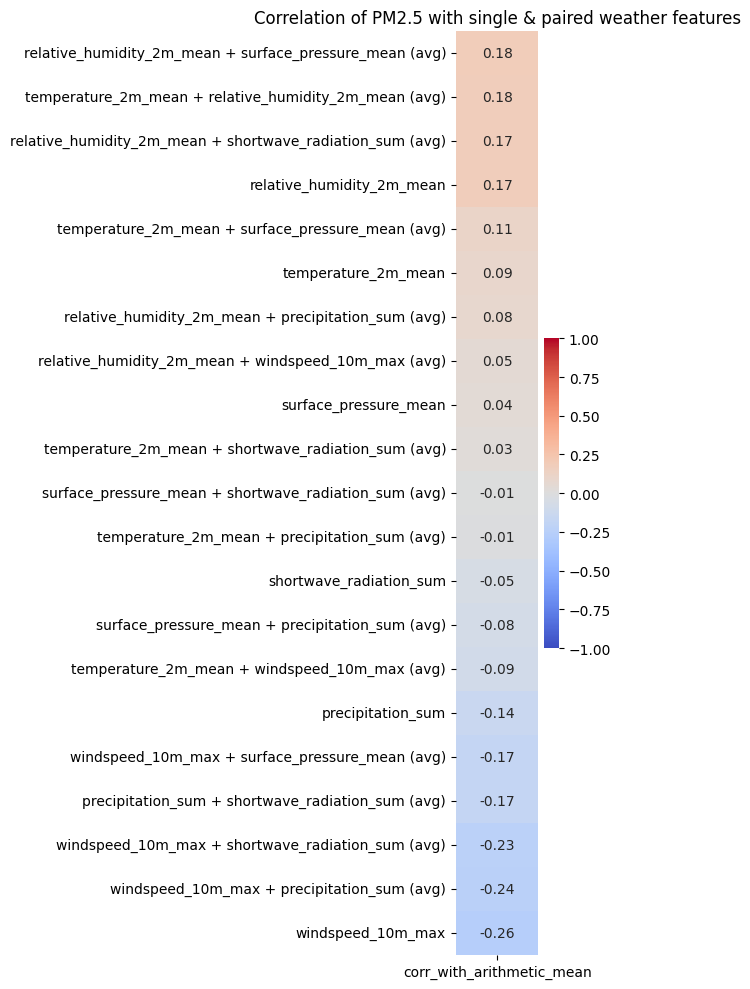

In [15]:
# Correlation heatmap: arithmetic_mean vs single and paired weather combos
import itertools
target = 'arithmetic_mean'
base_features = [
    'temperature_2m_mean',
    'relative_humidity_2m_mean',
    'windspeed_10m_max',
    'surface_pressure_mean',
    'precipitation_sum',
    'shortwave_radiation_sum',
]

data = df_clean[[target] + base_features].dropna().astype(float)
combo_cols = {}
for feat in base_features:
    combo_cols[feat] = data[feat]
for f1, f2 in itertools.combinations(base_features, 2):
    name = f"{f1} + {f2} (avg)"
    combo_cols[name] = data[[f1, f2]].mean(axis=1)
combo_df = pd.DataFrame(combo_cols)
corr_series = combo_df.corrwith(data[target])
corr_df = corr_series.to_frame(name='corr_with_arithmetic_mean')
plt.figure(figsize=(6,10))
sns.heatmap(corr_df.sort_values('corr_with_arithmetic_mean', ascending=False),
            cmap='coolwarm', annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation of PM2.5 with single & paired weather features')
plt.tight_layout()
plt.show()


### Manual linear tuning hasn't yielded strong metrics; let's try a simple machine learning regressor to see if non-linear patterns help.

## Trying scikit Learn RandomForestRegressor for Machine Learning
### Introducing a machine learning approach, plus a RandomForestRegressor code cell that trains/tests on the weather features, reports test R^2/MSE, and prints feature importances.

In [16]:
# Random Forest Regressor as a non-linear baseline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
target = 'arithmetic_mean'
features = [
    'temperature_2m_mean',
    'relative_humidity_2m_mean',
    'windspeed_10m_max',
    'surface_pressure_mean',
    'precipitation_sum',
    'shortwave_radiation_sum',
]
data = df_clean.dropna(subset=[target] + features).copy()
X = data[features].astype(float)
y = data[target].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=0,
    n_jobs=-1,
)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)
print('RandomForestRegressor on weather features')
print(f'R^2 (test): {r2:.4f}')
print(f'MSE (test): {mse:.4f}')
print('Feature importances:')
for name, imp in sorted(zip(features, rf.feature_importances_), key=lambda x: -x[1]):
    print(f'  {name}: {imp:.3f}')


RandomForestRegressor on weather features
R^2 (test): 0.3165
MSE (test): 17.1466
Feature importances:
  temperature_2m_mean: 0.241
  windspeed_10m_max: 0.240
  relative_humidity_2m_mean: 0.157
  shortwave_radiation_sum: 0.145
  surface_pressure_mean: 0.143
  precipitation_sum: 0.074


### The tree-based model performs noticeably better than our linear baselines; machine learning looks like the best path forward here.

## Trying scikit Learn Gradient Boosting for Machine Learning

In [17]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_hat = gbr.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)
print('GradientBoostingRegressor on weather features')
print(f'R^2 (test): {r2:.4f}')
print(f'MSE (test): {mse:.4f}')
print('Feature importances:')
for name, imp in sorted(zip(features, gbr.feature_importances_), key=lambda x: -x[1]):
    print(f'  {name}: {imp:.3f}')


GradientBoostingRegressor on weather features
R^2 (test): 0.2510
MSE (test): 18.7892
Feature importances:
  temperature_2m_mean: 0.285
  windspeed_10m_max: 0.195
  relative_humidity_2m_mean: 0.170
  surface_pressure_mean: 0.157
  precipitation_sum: 0.100
  shortwave_radiation_sum: 0.093


### The Gradient Boosting run produced a very low R^2, so it isn't a good fit for this dataset compared to the other models.

## Trying scikit Learn Extra Trees Regressor for Machine Learning

In [18]:
# Extra Trees Regressor
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=7,
    n_jobs=-1,
)
et.fit(X_train, y_train)
y_hat = et.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)
print('ExtraTreesRegressor on weather features')
print(f'R^2 (test): {r2:.4f}')
print(f'MSE (test): {mse:.4f}')
print('Feature importances:')
for name, imp in sorted(zip(features, et.feature_importances_), key=lambda x: -x[1]):
    print(f'  {name}: {imp:.3f}')


ExtraTreesRegressor on weather features
R^2 (test): 0.3055
MSE (test): 18.9202
Feature importances:
  windspeed_10m_max: 0.218
  temperature_2m_mean: 0.209
  relative_humidity_2m_mean: 0.170
  shortwave_radiation_sum: 0.162
  surface_pressure_mean: 0.134
  precipitation_sum: 0.107


### The Extra tree-based model performs worse than baseline but decent

In [19]:
# RandomForestRegressor on full 2020 data (no train/test split)
rf_full = RandomForestRegressor(n_estimators=400, random_state=0, n_jobs=-1)
rf_full.fit(X_train, y_train)
y_hat = rf_full.predict(X_train)
mse = mean_squared_error(y_train, y_hat)
r2 = r2_score(y_train, y_hat)
print('RandomForestRegressor (train=all 2020)')
print(f'R^2 (train): {r2:.4f}')
print(f'MSE (train): {mse:.4f}')


RandomForestRegressor (train=all 2020)
R^2 (train): 0.8823
MSE (train): 1.5502


### Out-of-time test (2021)
Pull a 2021 dataset to test the random forest on an unseen year and see how it generalizes.


In [20]:
# Pull PM2.5 for 2021

pm_params = {
    'email': email,
    'key': key,
    'param': '88101',
    'bdate': '20210101',
    'edate': '20211231',
    'state': '34',
    'county': '023',
}
pm_resp = requests.get(daily_url, params=pm_params)
pm_rows = pm_resp.json().get('Data', [])
for row in pm_rows:
    row['county_name'] = 'Middlesex'
with open('pm25_middlesex_2021_daily.json', 'w') as f:
    json.dump({'Data': pm_rows}, f, indent=2)


In [21]:
# Pull weather for 2021
meteo_params = {
    'latitude': 40.462182,
    'longitude': -74.429439,
    'start_date': '2021-01-01',
    'end_date': '2021-12-31',
    'daily': [
        'temperature_2m_max',
        'temperature_2m_min',
        'temperature_2m_mean',
        'relative_humidity_2m_mean',
        'windspeed_10m_max',
        'windgusts_10m_max',
        'surface_pressure_mean',
        'precipitation_sum',
        'shortwave_radiation_sum',
    ],
    'timezone': 'America/New_York',
}
meteo_resp = requests.get(url, params=meteo_params)
meteo_2021 = meteo_resp.json()
with open('meteo_middlesex_2021_daily.json', 'w') as f:
    json.dump(meteo_2021, f, indent=2)


In [22]:
# Merge and clean 2021 data
with open('pm25_middlesex_2021_daily.json', 'r') as f:
    pm_payload_2021 = json.load(f)
pm_df_2021 = pd.DataFrame(pm_payload_2021.get('Data', []))
if 'date_local' not in pm_df_2021.columns and 'date' in pm_df_2021.columns:
    pm_df_2021 = pm_df_2021.rename(columns={'date': 'date_local'})
pm_df_2021['date_local'] = pd.to_datetime(pm_df_2021['date_local'])
with open('meteo_middlesex_2021_daily.json', 'r') as f:
    meteo_payload_2021 = json.load(f)
meteo_daily_2021 = pd.DataFrame(meteo_payload_2021.get('daily', {}))
meteo_daily_2021 = meteo_daily_2021.rename(columns={'time': 'date_local'})
meteo_daily_2021['date_local'] = pd.to_datetime(meteo_daily_2021['date_local'])
df_merged_2021 = pd.merge(pm_df_2021, meteo_daily_2021, on='date_local', how='inner')
numeric_cols = [target, 'aqi'] + features
df_clean_2021 = df_merged_2021.sort_values('date_local').drop_duplicates(subset=['date_local'])
df_clean_2021[numeric_cols] = df_clean_2021[numeric_cols].apply(pd.to_numeric, errors='coerce')
df_clean_2021 = df_clean_2021[df_clean_2021[target] >= 0].dropna(subset=numeric_cols)
print('2021 cleaned rows:', len(df_clean_2021))
df_clean_2021.head()


2021 cleaned rows: 300


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,county_name,temperature_2m_max,temperature_2m_min,temperature_2m_mean,relative_humidity_2m_mean,windspeed_10m_max,windgusts_10m_max,surface_pressure_mean,precipitation_sum,shortwave_radiation_sum
0,34,023,0011,88101,1,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,7,...,Middlesex,5.0,-2.5,1.5,79,14.9,29.2,1026.7,9.1,4.70
932,34,023,0011,88101,3,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,X,...,Middlesex,10.9,1.0,6.1,81,29.3,65.2,1010.8,1.9,6.80
938,34,023,0011,88101,3,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,X,...,Middlesex,4.1,-0.3,2.0,89,19.1,37.1,1014.5,6.6,1.48
949,34,023,0011,88101,3,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,X,...,Middlesex,4.5,1.1,2.9,79,8.1,18.0,1011.3,0.0,3.01
961,34,023,0011,88101,3,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,X,...,Middlesex,5.4,-0.6,2.0,70,19.8,41.8,1014.0,0.0,9.15


In [23]:
# Train on 2020 data and test on 2021 with RandomForest

train_data = df_clean.dropna(subset=[target] + features).copy()
X_train = train_data[features].astype(float)
y_train = train_data[target].astype(float)
test_data = df_clean_2021.dropna(subset=[target] + features).copy()
X_test = test_data[features].astype(float)
y_test = test_data[target].astype(float)
rf_oot = RandomForestRegressor(n_estimators=400, random_state=0, n_jobs=-1)
rf_oot.fit(X_train, y_train)
y_pred = rf_oot.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('RandomForest OOT (train 2020, test 2021)')
print(f'R^2: {r2:.4f}')
print(f'MSE: {mse:.4f}')


RandomForest OOT (train 2020, test 2021)
R^2: 0.1505
MSE: 21.2814
